In [23]:
from collections import defaultdict
import sys
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine


engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [24]:
g = nx.read_gpickle('../Directed_Graphs/full690k.gpickle')

In [25]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

In [26]:
my_file = open("pgnparse.txt", "r")
pgn = my_file.read()

pgn_list = pgn.split("\n")
my_file.close()
print(len(pgn_list))

pgn_list = list(filter(None, pgn_list))
print(len(pgn_list))

242666
121332


In [27]:
pgn_list[1]

'[Event "Rated Classical game"  [Site "https://lichess.org/a9tcp02g"  [White "Desmond_Wilson"  [Black "savinka59"  [Result "1-0"  [UTCDate "2012.12.31"  [UTCTime "23:04:12"  [WhiteElo "1654"  [BlackElo "1919"  [WhiteRatingDiff "+19"  [BlackRatingDiff "-22"  [ECO "D04"  [Opening "Queen\'s Pawn Game: Colle System, Anti-Colle"  [TimeControl "480+2"  [Termination "Normal"   [mainline 1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nxg6 hxg6 6. Nd2 e6 7. Bd3 Bd6 8. e4 dxe4 9. Nxe4 Rxh2 10. Ke2 Rxh1 11. Qxh1 Nc6 12. Bg5 Ke7 13. Qh7 Nxd4+ 14. Kd2 Qe8 15. Qxg7 Qh8 16. Bxf6+ Kd7 17. Qxh8 Rxh8 18. Bxh8 1-0  '

In [28]:
start = timeit.default_timer()
d = defaultdict(list)
cnt = 0
for item in pgn_list:
    l = item.split('[mainline')
    try:
        info = l[0].split('"')
        #mainline = l[1]
        tuples = list(zip(info[::2],info[1::2]))
        tuples.append(('mainline', l[1]))

        for a, b in tuples:
            d[a].append(b)

        
    except:
         print('problem parsing:', item)
print("TIME:", timeit.default_timer()- start)

TIME: 0.9569765730000199


In [29]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
print(df.shape)
df.head(2)

(121332, 18)


,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,[BlackRatingDiff,[ECO,[Opening,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,-8,C00,French Defense: Normal Variation,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM


In [30]:
df['san'] = df.mainline.apply(lambda x: [ i for i in x.split() if "." not in i ])

In [31]:
df.head(2)

,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,[BlackRatingDiff,[ECO,[Opening,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle,san
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,-8,C00,French Defense: Normal Variation,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6..."
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx..."


In [32]:
def get_sd_score_from_san(san):
    board = chess.Board()
    sd_list = []
    score_list = []
    for move in san:
        try:
            board.push_san(move)
            currFen = board.fen()
            board = chess.Board(currFen)
            sf = engine.analyse(board, chess.engine.Limit(time=0.05))
            
            if('#' in str(sf['score'])):
                if('-' in str(sf['score'])):
                    sf =  -39765
                else:
                    sf =  39765
            else:
                sf = int(str(sf["score"]))*-1
            score_list.append(sf)
            scores = []
            counts = []
            for neighbor in list(g.neighbors(currFen)):
                scores.append(nx.get_node_attributes(g, 'score')[neighbor])
                counts.append(nx.get_node_attributes(g, 'count')[neighbor])

            sd_list.append(np.sqrt(varWeighted(scores, counts)))
        except:
            break
    return pd.Series([sd_list[::2],sd_list[1::2], score_list[::2],score_list[1::2]]) 
        ##white, black sd, white, black score
#     return(sd_list, score_list)

In [33]:
df_test = df.head(1000)

In [34]:
# df_small['sd_list'] = df.san.apply(lambda x: get_sd_score_from_san(x)[0])
# df_small['sf_list'] = df.san.apply(lambda x: get_sd_score_from_san(x)[1])
start = timeit.default_timer()
df_test[['sd_white', 'sd_black','score_white', 'score_black']] = df_test.san.apply(
    lambda x: get_sd_score_from_san(x))
print("TIME:",timeit.default_timer()-start)
df_test.head(2)

TIME: 820.983648788


/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,...,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle,san,sd_white,sd_black,score_white,score_black
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,...,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6...","[28.648963929729266, 57.549979943411046]","[60.966073184156144, 35.74346530819755]","[77, 58, 54]","[-72, -165]"
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,...,480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx...","[41.1940781891276, 31.459045320410564, 2.82842...","[45.28960056811188, 20.14694300405102]","[-12, 24, 30]","[-56, -43, -78]"


In [35]:
df_test['max_white_sd'] = df_test.sd_white.apply(lambda x: 0 if len(x) == 0 else max(x))
df_test['max_black_sd'] = df_test.sd_black.apply(lambda x: 0 if len(x) == 0 else max(x))

/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df_test.head(2)

,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,...,mainline,[BlackTitle,[WhiteTitle,san,sd_white,sd_black,score_white,score_black,max_white_sd,max_black_sd
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,...,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6...","[28.648963929729266, 57.549979943411046]","[60.966073184156144, 35.74346530819755]","[77, 58, 54]","[-72, -165]",57.549980,60.966073
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,...,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx...","[41.1940781891276, 31.459045320410564, 2.82842...","[45.28960056811188, 20.14694300405102]","[-12, 24, 30]","[-56, -43, -78]",41.194078,45.289601


In [37]:
df_test.columns

Index(['[Event ', '  [Site ', '  [White ', '  [Black ', '  [Result ',
       '  [UTCDate ', '  [UTCTime ', '  [WhiteElo ', '  [BlackElo ',
       '  [WhiteRatingDiff ', '  [BlackRatingDiff ', '  [ECO ', '  [Opening ',
       '  [TimeControl ', '  [Termination ', 'mainline', '  [BlackTitle ',
       '  [WhiteTitle ', 'san', 'sd_white', 'sd_black', 'score_white',
       'score_black', 'max_white_sd', 'max_black_sd'],
      dtype='object')

In [38]:
df_test['  [WhiteElo '] = df_test['  [WhiteElo '].apply(pd.to_numeric)
df_test['  [BlackElo '] = df_test['  [BlackElo '].apply(pd.to_numeric, errors= 'coerce')
df_test['elo_diff'] = df_test['  [WhiteElo '] - df_test['  [BlackElo ']

/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/choldawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

(0, 400)

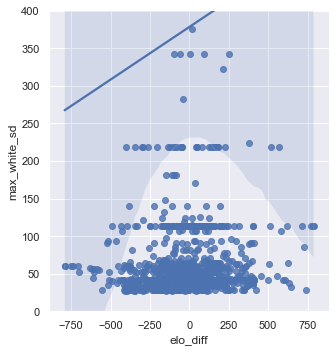

In [45]:
%matplotlib inline
import seaborn as sns; sns.set()

ax = sns.lmplot('elo_diff' , 'max_white_sd', data = df_test)
plt.ylim(0,400)